# colab
<a href="https://colab.research.google.com/github/Ykiiii/t-less_toolkit/blob/master/yk_pytless_20231130.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg alt=Open In Colab/></a>

In [1]:
# 挂载GD
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 挂载github
using_colab = True
if using_colab:
    import torch
    import torchvision
    print(PyTorch version: , torch.__version__)
    print( Torchvision version: , torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install vispy
    !{sys.executable} -m pip install 'git+https://github.com/Ykiiii/t-less_toolkit.git'


In [3]:
!git clone https://github.com/Ykiiii/t-less_toolkit.git


Cloning into 't-less_toolkit'...
remote: Enumerating objects: 224, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 224 (delta 5), reused 16 (delta 3), pack-reused 202
Receiving objects: 100% (224/224), 1.79 MiB | 9.52 MiB/s, done.
Resolving deltas: 100% (106/106), done.


In [ ]:
/content/t-less_toolkit/t-less_download.py

In [11]:
!python t-less_toolkit/t-less_download.py --help

usage: t-less_download.py [-h] [--destination DESTINATION] [--train [obj_id ...]]
                          [--test [scene_id ...]]
                          [--sensors {primesense,kinect,canon} [{primesense,kinect,canon} ...]]
                          [--models [{cad,cad_subdivided,reconst} ...]]

Downloads and unpacks the selected parts of the T-LESS dataset. Example usage: "t-less_download.py
--train --test --models --sensors primesense" - downloads and unpacks all models and all images
from the Primesense sensor.

options:
  -h, --help            show this help message and exit
  --destination DESTINATION
                        destination folder inside which a new folder for the dataset is created
                        (default is the current folder)
  --train [obj_id ...]  IDs of objects (all are downloaded if no ID is specified)
  --test [scene_id ...]
                        IDs of scenes (all are downloaded if no ID is specified)
  --sensors {primesense,kinect,canon} [{pri

In [ ]:
!echo -e '\n' | python t-less_toolkit/t-less_download.py --train  --test  --models cad --sensors primesense



In [21]:
!python /content/t-less_toolkit/check_poses_train_imgs.py

Traceback (most recent call last):
  File "/content/t-less_toolkit/check_poses_train_imgs.py", line 9, in <module>
    from pytless import inout, renderer, misc
  File "/content/t-less_toolkit/pytless/renderer.py", line 9, in <module>
    app.use_app('PyGlet') # Set backend
  File "/usr/local/lib/python3.10/dist-packages/vispy/app/_default_app.py", line 47, in use_app
    default_app = Application(backend_name)
  File "/usr/local/lib/python3.10/dist-packages/vispy/app/application.py", line 47, in __init__
    self._use(backend_name)
  File "/usr/local/lib/python3.10/dist-packages/vispy/app/application.py", line 240, in _use
    raise RuntimeError(msg)
RuntimeError: Could not import backend "Pyglet":
No module named 'pyglet'


In [ ]:
!zip -r /content/drive/MyDrive/Dataset/t-less_v2.zip /content/t-less_v2

In [16]:
!python check_poses_train_imgs.py

obj: 5, device: primesense, im_id: 0
obj: 5, device: primesense, im_id: 100
obj: 5, device: primesense, im_id: 200
obj: 5, device: primesense, im_id: 300
obj: 5, device: primesense, im_id: 400
obj: 5, device: primesense, im_id: 500
obj: 5, device: primesense, im_id: 600
obj: 5, device: primesense, im_id: 700
obj: 5, device: primesense, im_id: 800
obj: 5, device: primesense, im_id: 900
obj: 5, device: primesense, im_id: 1000
obj: 5, device: primesense, im_id: 1100
obj: 5, device: primesense, im_id: 1200


# 绘制视锥

In [7]:
# ----------------------------------------------------------------------------
# -                        Open3D: www.open3d.org                            -
# ----------------------------------------------------------------------------
# Copyright (c) 2018-2023 www.open3d.org
# SPDX-License-Identifier: MIT
# ----------------------------------------------------------------------------

import argparse
import os
import numpy as np
import open3d as o3d

POINTS_PER_FRUSTUM = 5
EDGES_PER_FRUSTUM = 8


def lineset_from_pose_graph(pose_graph):
    points = []
    colors = []
    lines = []

    cnt = 0
    for node in pose_graph.nodes:
        pose = np.array(node.pose)

        l = 0.1
        points.append((pose @ np.array([0, 0, 0, 1]).T)[:3])
        points.append((pose @ np.array([l, l, 2 * l, 1]).T)[:3])
        points.append((pose @ np.array([l, -l, 2 * l, 1]).T)[:3])
        points.append((pose @ np.array([-l, -l, 2 * l, 1]).T)[:3])
        points.append((pose @ np.array([-l, l, 2 * l, 1]).T)[:3])

        lines.append([cnt + 0, cnt + 1])
        lines.append([cnt + 0, cnt + 2])
        lines.append([cnt + 0, cnt + 3])
        lines.append([cnt + 0, cnt + 4])
        lines.append([cnt + 1, cnt + 2])
        lines.append([cnt + 2, cnt + 3])
        lines.append([cnt + 3, cnt + 4])
        lines.append([cnt + 4, cnt + 1])

        for i in range(0, EDGES_PER_FRUSTUM):
            colors.append(np.array([1, 0, 0]))

        cnt += POINTS_PER_FRUSTUM

    for edge in pose_graph.edges:
        s = edge.source_node_id
        t = edge.target_node_id
        lines.append([POINTS_PER_FRUSTUM * s, POINTS_PER_FRUSTUM * t])
        colors.append(
            np.array([0, 1, 0]) if edge.uncertain else np.array([0, 0, 1]))

    lineset = o3d.geometry.LineSet()
    lineset.points = o3d.utility.Vector3dVector(np.vstack(points))
    lineset.lines = o3d.utility.Vector2iVector(np.vstack(lines).astype(int))
    lineset.colors = o3d.utility.Vector3dVector(np.vstack(colors))

    return lineset


if __name__ == '__main__':
    # parser = argparse.ArgumentParser()
    # parser.add_argument('scene', help='path to reconstructed scene (.ply)')
    # parser.add_argument('--poses', type=str, help='path to pose graph')
    # args = parser.parse_args()

    # path_to_scene = args.scene
    scene = pcds[0]

    geometries = [scene]
    # if args.poses:
    #     path_to_posegraph = args.poses
    #     pose_graph = o3d.io.read_pose_graph(path_to_posegraph)
    pose_graph   = camera_poses[0]['extrinsic']
    lineset = lineset_from_pose_graph(pose_graph)
    geometries.append(lineset)

    o3d.visualization.draw_geometries(geometries)

AttributeError: 'numpy.ndarray' object has no attribute 'nodes'

In [9]:
# ----------------------------------------------------------------------------
# -                        Open3D: www.open3d.org                            -
# ----------------------------------------------------------------------------
# Copyright (c) 2018-2023 www.open3d.org
# SPDX-License-Identifier: MIT
# ----------------------------------------------------------------------------

import argparse
import os
import numpy as np
import open3d as o3d

POINTS_PER_FRUSTUM = 5
EDGES_PER_FRUSTUM = 8


def lineset_from_pose_graph(pose_graph):
    points = []
    colors = []
    lines = []

    cnt = 0
    for node in pose_graph.nodes:
        pose = np.array(node.pose)

        l = 0.1
        points.append((pose @ np.array([0, 0, 0, 1]).T)[:3])
        points.append((pose @ np.array([l, l, 2 * l, 1]).T)[:3])
        points.append((pose @ np.array([l, -l, 2 * l, 1]).T)[:3])
        points.append((pose @ np.array([-l, -l, 2 * l, 1]).T)[:3])
        points.append((pose @ np.array([-l, l, 2 * l, 1]).T)[:3])

        lines.append([cnt + 0, cnt + 1])
        lines.append([cnt + 0, cnt + 2])
        lines.append([cnt + 0, cnt + 3])
        lines.append([cnt + 0, cnt + 4])
        lines.append([cnt + 1, cnt + 2])
        lines.append([cnt + 2, cnt + 3])
        lines.append([cnt + 3, cnt + 4])
        lines.append([cnt + 4, cnt + 1])

        for i in range(0, EDGES_PER_FRUSTUM):
            colors.append(np.array([1, 0, 0]))

        cnt += POINTS_PER_FRUSTUM

    for edge in pose_graph.edges:
        s = edge.source_node_id
        t = edge.target_node_id
        lines.append([POINTS_PER_FRUSTUM * s, POINTS_PER_FRUSTUM * t])
        colors.append(
            np.array([0, 1, 0]) if edge.uncertain else np.array([0, 0, 1]))

    lineset = o3d.geometry.LineSet()
    lineset.points = o3d.utility.Vector3dVector(np.vstack(points))
    lineset.lines = o3d.utility.Vector2iVector(np.vstack(lines).astype(int))
    lineset.colors = o3d.utility.Vector3dVector(np.vstack(colors))

    return lineset


if __name__ == '__main__':
    # parser = argparse.ArgumentParser()
    # parser.add_argument('scene', help='path to reconstructed scene (.ply)')
    # parser.add_argument('--poses', type=str, help='path to pose graph')
    # args = parser.parse_args()

    # path_to_scene = args.scene
    scene = pcds[0]

    geometries = [scene]
    # if args.poses:
    #     path_to_posegraph = args.poses
    #     pose_graph = o3d.io.read_pose_graph(path_to_posegraph)
    pose_graph   = camera_poses[0]['extrinsic']
    lineset = lineset_from_pose_graph(pose_graph)
    geometries.append(lineset)

    o3d.visualization.draw_geometries(geometries)

array([[ 9.9990511e-01,  1.1904480e-02,  6.9681802e-03,  0.0000000e+00],
       [-1.1025990e-02,  9.9332482e-01, -1.1482101e-01,  0.0000000e+00],
       [-8.2885502e-03,  1.1473247e-01,  9.9336231e-01,  0.0000000e+00],
       [-1.4651644e+01, -1.8990402e+01, -6.3481335e+02,  1.0000000e+00]],
      dtype=float32)

# PnP

In [13]:
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import cv2,os,copy
from pytless import inout

['0000.png', '0001.png', '0002.png', '0003.png', '0004.png', '0005.png', '0006.png', '0007.png', '0008.png', '0009.png', '0010.png', '0011.png', '0012.png', '0013.png', '0014.png', '0015.png', '0016.png', '0017.png', '0018.png', '0019.png', '0020.png', '0021.png', '0022.png', '0023.png', '0024.png', '0025.png', '0026.png', '0027.png', '0028.png', '0029.png', '0030.png', '0031.png', '0032.png', '0033.png', '0034.png', '0035.png', '0036.png', '0037.png', '0038.png', '0039.png', '0040.png', '0041.png', '0042.png', '0043.png', '0044.png', '0045.png', '0046.png', '0047.png', '0048.png', '0049.png', '0050.png', '0051.png', '0052.png', '0053.png', '0054.png', '0055.png', '0056.png', '0057.png', '0058.png', '0059.png', '0060.png', '0061.png', '0062.png', '0063.png', '0064.png', '0065.png', '0066.png', '0067.png', '0068.png', '0069.png', '0070.png', '0071.png', '0072.png', '0073.png', '0074.png', '0075.png', '0076.png', '0077.png', '0078.png', '0079.png', '0080.png', '0081.png', '0082.png', '00

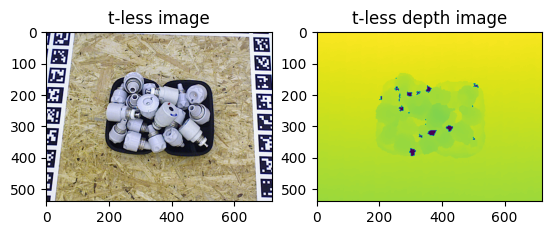

In [9]:
# 读取 展示
datadir = "E://DataSets//t-less_v2//test_primesense\\20\\"
print(os.listdir(datadir+'rgb'))

color_raw = o3d.io.read_image(datadir+'rgb\\0000.png')
depth_raw = o3d.io.read_image(datadir+'depth\\0000.png')

rgbd_image = o3d.geometry.RGBDImage.create_from_tum_format(
    color_raw, depth_raw,convert_rgb_to_intensity=False)
print(rgbd_image)
plt.subplot(1, 2, 1)
plt.title('t-less image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('t-less depth image')
plt.imshow(rgbd_image.depth)
# plt.show()
# show_rgbd(rgbd_image)

## aruco-code

In [1]:
import cv2
import cv2.aruco as aruco
import numpy as np
mtx=np.array([[398.12724231  , 0.      ,   304.35638757],
 [  0.       ,  345.38259888, 282.49861858],
 [  0.,           0.,           1.        ]])
dist=np.array(([[-0.58650416 , 0.59103816, -0.00443272 , 0.00357844 ,-0.27203275]]))

# Load the image
# img = cv2.imread(datadir+'rgb\\0000.png')
img = cv2.imread('RgbdData/testrgbd/111.png')
frame = img
font = cv2.FONT_HERSHEY_SIMPLEX #font for displaying text (below)
# img = cv2.imread('RgbdData/testrgbd/Snipaste_2023-12-04_09-39-06.png')

# Define the dictionary to use
dictionary = aruco.getPredefinedDictionary(aruco.DICT_6X6_50)

# Define the parameters for marker detection
parameters = aruco.DetectorParameters()

# Detect the markers in the image
corners, ids, rejectedImgPoints = aruco.detectMarkers(img, dictionary, parameters=parameters)

rvec, tvec, _ = aruco.estimatePoseSingleMarkers(corners, 0.05, mtx, dist)


# Draw the detected markers on the image
img_with_markers = aruco.drawDetectedMarkers(img, corners, ids)

(rvec-tvec).any() # get rid of that nasty numpy value array error

# aruco.drawAxis(frame, mtx, dist, rvec, tvec, 0.1) #绘制轴
# aruco.drawDetectedMarkers(frame, corners) #在标记周围画一个正方形

for i in range(rvec.shape[0]):
    aruco.drawAxis(frame, mtx, dist, rvec[i, :, :], tvec[i, :, :], 0.03)
    aruco.drawDetectedMarkers(frame, corners)
###### DRAW ID #####
cv2.putText(frame, "Id: " + str(ids), (0,64), font, 1, (0,255,0),2,cv2.LINE_AA)



# # Display the image
# cv2.imshow('Image with ArUco Markers', img_with_markers)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


AttributeError: module 'cv2.aruco' has no attribute 'drawAxis'

In [6]:
cv2.imshow(img)

error: OpenCV(4.8.1) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)


In [10]:
img.shape

(860, 1141, 3)

In [11]:
img_with_markers.shape

(860, 1141, 3)

## artoolkitplus-code

In [10]:
import cv2
image = cv2.imread('RgbdData/testrgbd/Snipaste_2023-12-04_09-37-59.png')
# Assume that the image containing the BCH code is stored in a NumPy array called 'image'
# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Threshold the grayscale image to create a binary image
ret, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

# Find the contours in the binary image
contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the original image
cv2.drawContours(image, contours, -1, (0, 255, 0), 3)

# Display the image
cv2.imshow('Image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()


# rebuild mesh

In [110]:
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import cv2,os,copy,yaml

['0000.png', '0001.png', '0002.png', '0003.png', '0004.png', '0005.png', '0006.png', '0007.png', '0008.png', '0009.png', '0010.png', '0011.png', '0012.png', '0013.png', '0014.png', '0015.png', '0016.png', '0017.png', '0018.png', '0019.png', '0020.png', '0021.png', '0022.png', '0023.png', '0024.png', '0025.png', '0026.png', '0027.png', '0028.png', '0029.png', '0030.png', '0031.png', '0032.png', '0033.png', '0034.png', '0035.png', '0036.png', '0037.png', '0038.png', '0039.png', '0040.png', '0041.png', '0042.png', '0043.png', '0044.png', '0045.png', '0046.png', '0047.png', '0048.png', '0049.png', '0050.png', '0051.png', '0052.png', '0053.png', '0054.png', '0055.png', '0056.png', '0057.png', '0058.png', '0059.png', '0060.png', '0061.png', '0062.png', '0063.png', '0064.png', '0065.png', '0066.png', '0067.png', '0068.png', '0069.png', '0070.png', '0071.png', '0072.png', '0073.png', '0074.png', '0075.png', '0076.png', '0077.png', '0078.png', '0079.png', '0080.png', '0081.png', '0082.png', '00

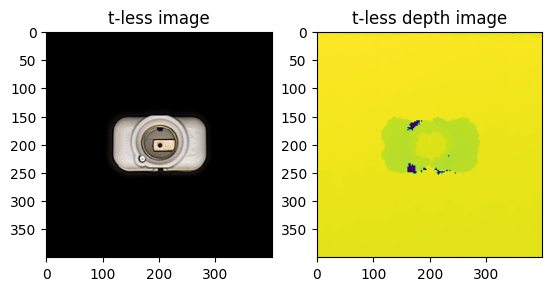

In [112]:
# 读取 展示
datadir = "E:\\DataSets\\t-less_v2\\train_primesense\\05\\"
print(os.listdir(datadir+'rgb'))

color_raw = o3d.io.read_image(datadir+'rgb\\0000.png')
depth_raw = o3d.io.read_image(datadir+'depth\\0000.png')

rgbd_image = o3d.geometry.RGBDImage.create_from_tum_format(
    color_raw, depth_raw,convert_rgb_to_intensity=False)

print(rgbd_image)
plt.subplot(1, 2, 1)
plt.title('t-less image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('t-less depth image')
plt.imshow(rgbd_image.depth)
# plt.show()
# show_rgbd(rgbd_image)
width, height, = np.asarray(depth_raw).shape[0],np.asarray(depth_raw).shape[1]
intr  = o3d.camera.PinholeCameraIntrinsic(width, height,1075.65091572,1073.90347929,225.06888344,167.72159802)
coor = o3d.geometry.TriangleMesh.create_coordinate_frame()
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,intr
    )
# Flip it, otherwise the pointcloud will be upside down
# pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd,coor])

## 从相机位姿出发
### 从测试数据获取位姿

In [155]:
# get camera pose from test_data
def read_trajectory(filename): 
    with open(filename, 'r') as f: 
        data = yaml.safe_load(f) 
        for item in data: 

            # intrinsic
            cam_K = data[item]['cam_K'] 
            # data[item]['intrinsic'] = np.array(cam_K).reshape(3, 3) 
            data[item]['intrinsic'] = [cam_K[0],cam_K[4],cam_K[2],cam_K[5]] 
 
            # extrinsic 
            cam_R_w2c = data[item]['cam_R_w2c'] 
            cam_t_w2c = data[item]['cam_t_w2c'] 
            r = np.array(cam_R_w2c).reshape(3, 3) 
            t = np.array(cam_t_w2c).reshape(3, 1) * 0.002
            data[item]['r'] = r 
            data[item]['t'] = t 
 
            # extrinsic 
            # mat_view = np.eye(4, dtype=np.float32) # From world space to eye space 
            # mat_view[:3, :3], mat_view[3, :3] = r.T, t.T 
            # trans = np.array( 
            #     [ 
            #         [ 1, -1, -1, 1], 
            #         [ 1, -1, -1, 1], 
            #         [ 1, -1, -1, 1], 
            #         [ 1, -1, -1, 1] 
            #     ] 
            # ) 
            # data[item]['extrinsic'] = np.multiply(mat_view,trans) 
            
            # extrinsic 
            mat_view = np.eye(4, dtype=np.float32) # From world space to eye space 
            mat_view[:3, :3], mat_view[:3, 3] = r, t.squeeze() 
            data[item]['extrinsic'] = mat_view 
            # yz_flip = np.eye(4, dtype=np.float32) 
            # yz_flip[1, 1], yz_flip[2, 2] = -1,-1 
            # data[item]['extrinsic'] = yz_flip.dot(data[item]['extrinsic']).T
    return data 
 
filename = "E:/DataSets/t-less_v2/test_primesense/20/info.yml"
camera_poses = read_trajectory(filename) 

print(camera_poses[1]['r']) 
print(camera_poses[1]['t']) 
print(camera_poses[1]['extrinsic'])

[[ 0.116212 -0.993172  0.010203]
 [-0.952608 -0.114361 -0.281887]
 [ 0.281129  0.023039 -0.959393]]
[[-0.0213552]
 [ 0.0351242]
 [ 1.573918 ]]
[[ 0.116212  -0.993172   0.010203  -0.0213552]
 [-0.952608  -0.114361  -0.281887   0.0351242]
 [ 0.281129   0.023039  -0.959393   1.573918 ]
 [ 0.         0.         0.         1.       ]]


### 从训练数据获取位姿

In [150]:
# get camera pose from train_data
def read_trajectory(file_dir): 
    # file_dir = "E:/DataSets/t-less_v2/train_primesense/03/"
    gt_dir = file_dir+"gt.yml"
    info_dir = file_dir+"info.yml"
    with open(gt_dir, 'r') as f: 
        data1 = yaml.safe_load(f) 
    with open(info_dir, 'r') as f: 
        data2 = yaml.safe_load(f) 
    data = {}
    for item in range(len(data1)):
        data[item] = dict(data1[item][0], **data2[item])

 
    for item in data: 

        # intrinsic
        cam_K = data[item]['cam_K'] 
        # data[item]['intrinsic'] = np.array(cam_K).reshape(3, 3) 
        data[item]['intrinsic'] = [cam_K[0],cam_K[4],cam_K[2],cam_K[5]] 

        # extrinsic 
        cam_R_m2c = data[item]['cam_R_m2c'] 
        cam_t_m2c = data[item]['cam_t_m2c'] 
        r = np.array(cam_R_m2c).reshape(3, 3) 
        t = np.array(cam_t_m2c).reshape(3, 1)*0.002
        data[item]['r'] = r 
        data[item]['t'] = t
        """
        # extrinsic 
        mat_view = np.eye(4, dtype=np.float32) # From world space to eye space 
        mat_view[:3, :3], mat_view[3, :3] = r.T, t.T 
        
        data[item]['extrinsic'] = np.multiply(mat_view,trans) 

        """
        # t = -r @ t
        # extrinsic 
        mat_view = np.eye(4, dtype=np.float32) # From world space to eye space 
        mat_view[:3, :3], mat_view[:3, 3] = r, t.squeeze() 
        data[item]['extrinsic'] = mat_view
        # yz_flip = np.eye(4, dtype=np.float32) 
        # yz_flip[1, 1], yz_flip[2, 2] = -1,-1 
        # data[item]['extrinsic'] = yz_flip.dot(data[item]['extrinsic']).T
        
    return data

file_dir = "E:/DataSets/t-less_v2/train_primesense/05/"
camera_poses = read_trajectory(file_dir)
print(camera_poses[0]['r']) 
print(camera_poses[0]['t']) 
print(camera_poses[0]['extrinsic'])
# print(camera_poses[1])

[[ 0.99990513 -0.01102599 -0.00828855]
 [-0.01190448 -0.99332479 -0.11473247]
 [-0.00696818  0.11482101 -0.99336228]]
[[-0.02930329]
 [ 0.03798081]
 [ 1.26962667]]
[[ 0.9999051  -0.01102599 -0.00828855 -0.02930329]
 [-0.01190448 -0.9933248  -0.11473247  0.03798081]
 [-0.00696818  0.11482101 -0.9933623   1.2696266 ]
 [ 0.          0.          0.          1.        ]]


In [5]:
for i in range(0,500,50):
    width, height = 400,400
    intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height,  
                                                camera_poses[i]['intrinsic'][0], 
                                                camera_poses[i]['intrinsic'][1], 
                                                camera_poses[i]['intrinsic'][2], 
                                                camera_poses[i]['intrinsic'][3],) 
    print(camera_poses[i]['intrinsic'][0], 
          camera_poses[i]['intrinsic'][1], 
          camera_poses[i]['intrinsic'][2], 
          camera_poses[i]['intrinsic'][3],)
    

1075.65091572 1073.90347929 225.06888344 167.72159802
1075.65091572 1073.90347929 222.06888344 171.72159802
1075.65091572 1073.90347929 225.06888344 186.72159802
1075.65091572 1073.90347929 225.06888344 196.72159802
1075.65091572 1073.90347929 221.06888344 198.72159802
1075.65091572 1073.90347929 223.06888344 213.72159802
1075.65091572 1073.90347929 225.06888344 222.72159802
1075.65091572 1073.90347929 221.06888344 222.72159802
1075.65091572 1073.90347929 221.06888344 234.72159802
1075.65091572 1073.90347929 224.06888344 243.72159802


### 从位姿重建mesh

In [157]:
volume = o3d.pipelines.integration.ScalableTSDFVolume(
    voxel_length=4.0 / 512.0,
    sdf_trunc=0.04,
    color_type=o3d.pipelines.integration.TSDFVolumeColorType.RGB8)

# width, height = 400,400
# DataFolder = "E:/DataSets/t-less_v2/train_primesense/05/"

width, height = 720,540
DataFolder = "E:/DataSets/t-less_v2/test_primesense/20/"

rgbd_color_paths = [DataFolder+"/rgb/"+os.path.relpath(i) for i in os.listdir(DataFolder+"/rgb")]
rgbd_depth_paths = [DataFolder+"/depth/"+os.path.relpath(i) for i in os.listdir(DataFolder+"/depth")]


for i in range(0,500,100): 
    print("Integrate {:d}-th image into the volume.".format(i))
    color = o3d.io.read_image(rgbd_color_paths[i]) 
    depth = o3d.io.read_image(rgbd_depth_paths[i]) 
    # depth = o3d.geometry.Image((np.asarray(depth)*0.1).astype(np.uint16))
    
    rgbd = o3d.geometry.RGBDImage.create_from_tum_format( 
        color, depth, convert_rgb_to_intensity=False 
        ) 
        
    intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height,  
                                                    camera_poses[i]['intrinsic'][0], 
                                                    camera_poses[i]['intrinsic'][1], 
                                                    camera_poses[i]['intrinsic'][2], 
                                                    camera_poses[i]['intrinsic'][3],) 
  
    volume.integrate( 
        rgbd, 
        intrinsic, 
        # np.linalg.inv(camera_poses[i]['extrinsic']),
        camera_poses[i]['extrinsic']
        )
    # print(camera_poses[i]['extrinsic'])



Integrate 0-th image into the volume.
Integrate 100-th image into the volume.
Integrate 200-th image into the volume.
Integrate 300-th image into the volume.
Integrate 400-th image into the volume.


In [158]:
coor = o3d.geometry.TriangleMesh.create_coordinate_frame()
print("Extract a triangle mesh from the volume and visualize it.")
mesh = volume.extract_triangle_mesh()
mesh.compute_vertex_normals()

# mesh_t = copy.deepcopy(mesh).translate((camera_poses[0]['t']))

# mesh.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([mesh,coor],
                                #   front = [ -0.1443816094594301, 0.056668181145239756, -0.98789810613017925 ],
                                #   lookat = [ 0.44524144506360946, -0.24943087103334916, 0.64368316112433688 ],
                                #   up = [ -0.80214600288513505, 0.57788137578293208, 0.15038253082930331 ],
                                #   zoom = 0.7
                                  )

Extract a triangle mesh from the volume and visualize it.


In [112]:
coor_list = []
for i in range(0,1300,200): 
    # viewmax = np.linalg.inv(camera_poses[i]['extrinsic'])
    # viewmax = camera_poses[i]['extrinsic']
    r,t = camera_poses[i]['r'].T,camera_poses[i]['t']
    # print(t)
    coor_0 = copy.deepcopy(coor).rotate(r,
                                    center=tuple(t.reshape(3)*0.001))
    coor_list.append(coor_0)

In [38]:
print(camera_poses[0]['extrinsic'].T)
print(np.linalg.inv(camera_poses[0]['extrinsic']))

[[ 9.9990511e-01 -1.1904480e-02 -6.9681802e-03 -1.4651644e+01]
 [ 1.1025990e-02  9.9332482e-01 -1.1482101e-01 -1.8990402e+01]
 [ 8.2885502e-03  1.1473247e-01  9.9336231e-01 -6.3481335e+02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
[[ 9.9990463e-01 -1.1904497e-02 -6.9681797e-03 -0.0000000e+00]
 [ 1.1025979e-02  9.9332529e-01 -1.1482019e-01 -0.0000000e+00]
 [ 8.2885465e-03  1.1473323e-01  9.9336129e-01 -0.0000000e+00]
 [ 2.0121313e+01  9.1523407e+01  6.2831647e+02  1.0000000e+00]]


In [39]:
viewmax = np.linalg.inv(camera_poses[0]['extrinsic'])
r,t = viewmax[:3,:3],viewmax[3,:3]
print(r,t)

[[ 0.99990463 -0.0119045  -0.00696818]
 [ 0.01102598  0.9933253  -0.11482019]
 [ 0.00828855  0.11473323  0.9933613 ]] [ 20.121313  91.52341  628.31647 ]


### 从点云变换

In [74]:
volume = o3d.pipelines.integration.ScalableTSDFVolume(
    voxel_length=4.0 / 512.0,
    sdf_trunc=0.04,
    color_type=o3d.pipelines.integration.TSDFVolumeColorType.RGB8)

width, height = 400,400
DataFolder = "E:/DataSets/t-less_v2/train_primesense/05/"

# width, height = 720,540
# DataFolder = "E:/DataSets/t-less_v2/test_primesense/20/"

rgbd_color_paths = [DataFolder+"/rgb/"+os.path.relpath(i) for i in os.listdir(DataFolder+"/rgb")]
rgbd_depth_paths = [DataFolder+"/depth/"+os.path.relpath(i) for i in os.listdir(DataFolder+"/depth")]

pcds = []
for i in range(0,1300,200): 
    print("Integrate {:d}-th image into the volume.".format(i))
    color = o3d.io.read_image(rgbd_color_paths[i]) 
    depth = o3d.io.read_image(rgbd_depth_paths[i]) 
    # depth = o3d.geometry.Image((np.asarray(depth)*0.1).astype(np.uint16))
    
    rgbd = o3d.geometry.RGBDImage.create_from_tum_format( 
        color, depth, convert_rgb_to_intensity=False 
        ) 
        
    intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height,  
                                                    camera_poses[i]['intrinsic'][0], 
                                                    camera_poses[i]['intrinsic'][1], 
                                                    camera_poses[i]['intrinsic'][2], 
                                                    camera_poses[i]['intrinsic'][3],) 

    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd,intrinsic)

    viewmax = np.linalg.inv(camera_poses[i]['extrinsic'])
    r,t = viewmax[:3,:3],viewmax[3,:3]
    t = -r.dot(t)
    pcd_0 = copy.deepcopy(pcd).rotate(r,
                                    center=tuple(t.reshape(3)*0.001))
    

    
    pcds.append(pcd_0)
                            
    # volume.integrate( 
    #     rgbd, 
    #     intrinsic, 
    #     np.linalg.inv(camera_poses[i]['extrinsic']),
    #     # camera_poses[i]['extrinsic']
    #     )
    # # print(camera_poses[i]['extrinsic'])



Integrate 0-th image into the volume.
Integrate 200-th image into the volume.
Integrate 400-th image into the volume.
Integrate 600-th image into the volume.
Integrate 800-th image into the volume.
Integrate 1000-th image into the volume.
Integrate 1200-th image into the volume.


In [75]:
o3d.visualization.draw_geometries(pcds)

### 从model渲染

In [10]:
# datadir = "E:/DataSets/t-less_v2/models_cad/obj_05.ply"
# mesh = inout.load_ply(datadir)
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(mesh['pts'])
# coor = o3d.geometry.TriangleMesh.create_coordinate_frame()
# o3d.visualization.draw_geometries([pcd,coor],mesh_show_wireframe=True)

In [145]:
datadir = "E:/DataSets/t-less_v2/models_cad/obj_05.ply"
mesh = o3d.io.read_triangle_mesh(datadir)
mesh.compute_vertex_normals()
pcd_m0 = mesh.sample_points_uniformly(number_of_points=5000)
pcd_m0 = pcd_m0.scale(0.002, center=(0,0,0))
coor = o3d.geometry.TriangleMesh.create_coordinate_frame()
# o3d.visualization.draw_geometries([pcd_m0,coor],mesh_show_wireframe=True)

In [146]:
t = camera_poses[0]['t']*0.002
# t = t*np.array([[1],[1],[0.01]])
r = camera_poses[0]['r']
mat_view = np.eye(4, dtype=np.float32) # From world space to eye space 
mat_view[:3, :3], mat_view[:3, 3] = r, t.squeeze()
mat_view

array([[ 0.9999051 , -0.01102599, -0.00828855, -0.02930329],
       [-0.01190448, -0.9933248 , -0.11473247,  0.03798081],
       [-0.00696818,  0.11482101, -0.9933623 ,  1.2696266 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],
      dtype=float32)

In [147]:
pcd_m1 = copy.deepcopy(pcd_m0)
trans_mat = mat_view
pcd_m1.transform(trans_mat)
o3d.visualization.draw_geometries([pcd_m0,pcd_m1,pcd,coor],mesh_show_wireframe=True)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 句柄无效。 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 句柄无效。 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 句柄无效。 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 不支持请求的转换操作。 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 不支持请求的转换操作。 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 不支持请求的转换操作。 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 句柄无效。 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 不支持请求的转换操作。 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 句柄无效。 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 句柄无效。 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 不支持请求的转换操作。 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 句柄无效。 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 不支持请求的转换操作。 
[Open3D WARNING

In [148]:
pcd_1 = copy.deepcopy(pcd)
trans_mat = np.linalg.inv(mat_view)
pcd_1.transform(trans_mat)
o3d.visualization.draw_geometries([pcd_m0,pcd_m1,pcd,pcd_1,coor],mesh_show_wireframe=True)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 句柄无效。 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 句柄无效。 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 不支持请求的转换操作。 


## 从点云多向registration
### 去掉平面

In [6]:
# 离群点删除
def remove_outlier(pcd):
    down_pcd = pcd.uniform_down_sample(every_k_points=5)
    # down_pcd = inlier_cloud.voxel_down_sample(voxel_size=0.02)
    cl, ind = down_pcd.remove_radius_outlier(nb_points=5, radius=0.05)
    # cl, ind = down_pcd.remove_statistical_outlier(nb_neighbors=20,
                                                        # std_ratio=2)
    inlier_pcd = cl.select_by_index(ind)
    return inlier_pcd

# 平面检测
# 用ransac分割几何基元，找到支持度最大的平面
def get_plane(pcd):
    plane_model, inliers = pcd.segment_plane(distance_threshold=0.01, # 一个点与一个估计的平面的最大距离，超过即立群
                                            ransac_n=3,              # 平面随机采样点数量
                                            num_iterations=1000)     # 随机平面被采样和验证的频率
    [a, b, c, d] = plane_model                                        # 对于(x,y,z)，若ax+by+cz+d=0，则该点在平面上
    print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

    inlier_cloud = pcd.select_by_index(inliers)
    # inlier_cloud.paint_uniform_color([1, 0, 0])
    # outlier_cloud = pcd.select_by_index(inliers, invert=True)
    plane = inlier_cloud
    return plane

# 去除平面
def remove_plane(pcd,plane):
    # 计算包围盒
    obb = plane.get_oriented_bounding_box()
    # obb.color = (0, 1, 0)
    outside_points = pcd.select_by_index(obb.get_point_indices_within_bounding_box(pcd.points), invert=True)
    obj_pcd = remove_outlier(outside_points)

    return obj_pcd

# 缩小obb
def min_obb(pcd,plane,x = 0.45):
    # 计算包围盒
    obb = plane.get_oriented_bounding_box()
    # obb.color = (0, 1, 0)
    # outside_points = pcd.select_by_index(obb.get_point_indices_within_bounding_box(pcd.points), invert=True)
    # obj_pcd = remove_outlier(outside_points)
    # 缩小包围盒
    obb.extent = obb.extent*np.array([x,x,20])
    cropped_pcd = pcd.crop(obb)

    return cropped_pcd


### 获取obj点云列表

In [4]:

# width, height = 720,540
# DataFolder = "E:/DataSets/t-less_v2/test_primesense/20/"

width, height = 400,400
DataFolder = "E:/DataSets/t-less_v2/train_primesense/05/"

rgbd_color_paths = [DataFolder+"/rgb/"+os.path.relpath(i) for i in os.listdir(DataFolder+"/rgb")]
rgbd_depth_paths = [DataFolder+"/depth/"+os.path.relpath(i) for i in os.listdir(DataFolder+"/depth")]
pcds = []

for i in range(200,400,10): 
    print("Integrate {:d}-th image into the volume.".format(i))
    color = o3d.io.read_image(rgbd_color_paths[i]) 
    depth = o3d.io.read_image(rgbd_depth_paths[i]) 
    
    rgbd = o3d.geometry.RGBDImage.create_from_tum_format( 
        color, depth, convert_rgb_to_intensity=False 
        ) 
    
    intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height,  
                                                camera_poses[i]['intrinsic'][0], 
                                                camera_poses[i]['intrinsic'][1], 
                                                camera_poses[i]['intrinsic'][2], 
                                                camera_poses[i]['intrinsic'][3],) 
    
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
        rgbd,
        intrinsic)
    
    # 去掉平面
    plane = get_plane(pcd)
    obj_max = min_obb(pcd,plane,0.45)
    obj_pcd = remove_plane(obj_max,plane)
    pcd = obj_pcd

    radius_normal = 0.005*2
    pcd.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    # 翻转，相机小孔成像
    pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
    pcds.append(pcd)


Integrate 200-th image into the volume.
Plane equation: 0.01x + 0.45y + 0.89z + -1.19 = 0
Integrate 210-th image into the volume.
Plane equation: 0.02x + 0.45y + 0.89z + -1.19 = 0
Integrate 220-th image into the volume.
Plane equation: 0.01x + 0.59y + 0.80z + -1.07 = 0
Integrate 230-th image into the volume.
Plane equation: 0.01x + 0.59y + 0.80z + -1.07 = 0
Integrate 240-th image into the volume.
Plane equation: 0.01x + 0.60y + 0.80z + -1.07 = 0
Integrate 250-th image into the volume.
Plane equation: 0.01x + 0.60y + 0.80z + -1.07 = 0
Integrate 260-th image into the volume.
Plane equation: 0.01x + 0.60y + 0.80z + -1.07 = 0
Integrate 270-th image into the volume.
Plane equation: 0.01x + 0.59y + 0.80z + -1.07 = 0
Integrate 280-th image into the volume.
Plane equation: 0.01x + 0.60y + 0.80z + -1.07 = 0
Integrate 290-th image into the volume.
Plane equation: 0.01x + 0.72y + 0.69z + -0.92 = 0
Integrate 300-th image into the volume.
Plane equation: 0.01x + 0.72y + 0.69z + -0.92 = 0
Integrate 

In [5]:
# o3d.visualization.draw_geometries([pcds[1]])
o3d.visualization.draw_geometries(pcds)

In [21]:
for i in range(len(pcds)):
    o3d.visualization.draw_geometries([pcds[i]])

In [63]:
# plane_model, inliers = pcd.segment_plane(distance_threshold=0.01, # 一个点与一个估计的平面的最大距离，超过即立群
#                                         ransac_n=3,              # 平面随机采样点数量
#                                         num_iterations=1000)     # 随机平面被采样和验证的频率
# [a, b, c, d] = plane_model                                        # 对于(x,y,z)，若ax+by+cz+d=0，则该点在平面上
# print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

# inlier_cloud = pcd.select_by_index(inliers)
# inlier_cloud.paint_uniform_color([1, 0, 0])
# outlier_cloud = pcd.select_by_index(inliers, invert=True)
# obb = plane.get_oriented_bounding_box()
# obb.extent = obb.extent*np.array([0.45,0.45,20])
# obb.color = (0, 1, 0)
# o3d.visualization.draw_geometries([inlier_cloud,outlier_cloud,obb])

Plane equation: -0.01x + 0.45y + 0.89z + 1.19 = 0


### 多向registrain

In [7]:
def pairwise_registration(source, target):
    print("Apply point-to-plane ICP")
    icp_coarse = o3d.pipelines.registration.registration_icp(
        source, target, max_correspondence_distance_coarse, np.identity(4),
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    icp_fine = o3d.pipelines.registration.registration_icp(
        source, target, max_correspondence_distance_fine,
        icp_coarse.transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    transformation_icp = icp_fine.transformation
    information_icp = o3d.pipelines.registration.get_information_matrix_from_point_clouds(
        source, target, max_correspondence_distance_fine,
        icp_fine.transformation)
    return transformation_icp, information_icp


def full_registration(pcds, max_correspondence_distance_coarse,
                      max_correspondence_distance_fine):
    pose_graph = o3d.pipelines.registration.PoseGraph()
    odometry = np.identity(4)
    pose_graph.nodes.append(o3d.pipelines.registration.PoseGraphNode(odometry))
    n_pcds = len(pcds)
    for source_id in range(n_pcds):
        for target_id in range(source_id + 1, n_pcds):
            transformation_icp, information_icp = pairwise_registration(
                pcds[source_id], pcds[target_id])
            print("Build o3d.pipelines.registration.PoseGraph")
            if target_id == source_id + 1:  # odometry case
                odometry = np.dot(transformation_icp, odometry)
                pose_graph.nodes.append(
                    o3d.pipelines.registration.PoseGraphNode(
                        np.linalg.inv(odometry)))
                pose_graph.edges.append(
                    o3d.pipelines.registration.PoseGraphEdge(source_id,
                                                             target_id,
                                                             transformation_icp,
                                                             information_icp,
                                                             uncertain=False))
            else:  # loop closure case
                pose_graph.edges.append(
                    o3d.pipelines.registration.PoseGraphEdge(source_id,
                                                             target_id,
                                                             transformation_icp,
                                                             information_icp,
                                                             uncertain=True))
    return pose_graph
print("Full registration ...")
voxel_size = 0.02
max_correspondence_distance_coarse = voxel_size * 15
max_correspondence_distance_fine = voxel_size * 1.5
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    pose_graph = full_registration(pcds,
                                   max_correspondence_distance_coarse,
                                   max_correspondence_distance_fine)



Full registration ...
Apply point-to-plane ICP
[Open3D DEBUG] ICP Iteration #0: Fitness 1.0000, RMSE 0.0130
[Open3D DEBUG] Residual : 1.34e-04 (# of elements : 3086)
[Open3D DEBUG] ICP Iteration #1: Fitness 1.0000, RMSE 0.0169
[Open3D DEBUG] Residual : 2.05e-04 (# of elements : 3086)
[Open3D DEBUG] ICP Iteration #2: Fitness 1.0000, RMSE 0.0122
[Open3D DEBUG] Residual : 7.48e-05 (# of elements : 3086)
[Open3D DEBUG] ICP Iteration #3: Fitness 1.0000, RMSE 0.0121
[Open3D DEBUG] Residual : 5.96e-05 (# of elements : 3086)
[Open3D DEBUG] ICP Iteration #4: Fitness 1.0000, RMSE 0.0123
[Open3D DEBUG] Residual : 5.64e-05 (# of elements : 3086)
[Open3D DEBUG] ICP Iteration #5: Fitness 1.0000, RMSE 0.0124
[Open3D DEBUG] Residual : 5.67e-05 (# of elements : 3086)
[Open3D DEBUG] ICP Iteration #6: Fitness 1.0000, RMSE 0.0124
[Open3D DEBUG] Residual : 5.71e-05 (# of elements : 3086)
[Open3D DEBUG] ICP Iteration #7: Fitness 1.0000, RMSE 0.0125
[Open3D DEBUG] Residual : 5.76e-05 (# of elements : 3086)
[

In [8]:
print("Optimizing PoseGraph ...")
option = o3d.pipelines.registration.GlobalOptimizationOption(
    max_correspondence_distance=max_correspondence_distance_fine,
    edge_prune_threshold=0.25,
    reference_node=0)
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    o3d.pipelines.registration.global_optimization(
        pose_graph,
        o3d.pipelines.registration.GlobalOptimizationLevenbergMarquardt(),
        o3d.pipelines.registration.GlobalOptimizationConvergenceCriteria(),
        option)


Optimizing PoseGraph ...
[Open3D DEBUG] Validating PoseGraph - finished.
[Open3D DEBUG] [GlobalOptimizationLM] Optimizing PoseGraph having 20 nodes and 190 edges.
[Open3D DEBUG] Line process weight : 2.490205
[Open3D DEBUG] [Initial     ] residual : 9.845931e+05, lambda : 1.927773e-01
[Open3D DEBUG] [Iteration 00] residual : 3.703869e+02, valid edges : 22, time : 0.001 sec.
[Open3D DEBUG] [Iteration 01] residual : 3.657050e+02, valid edges : 26, time : 0.001 sec.
[Open3D DEBUG] [Iteration 02] residual : 3.655041e+02, valid edges : 25, time : 0.003 sec.
[Open3D DEBUG] [Iteration 03] residual : 3.513648e+02, valid edges : 31, time : 0.001 sec.
[Open3D DEBUG] [Iteration 04] residual : 3.325053e+02, valid edges : 47, time : 0.001 sec.
[Open3D DEBUG] [Iteration 05] residual : 3.301565e+02, valid edges : 47, time : 0.001 sec.
[Open3D DEBUG] [Iteration 06] residual : 3.146936e+02, valid edges : 47, time : 0.001 sec.
[Open3D DEBUG] [Iteration 07] residual : 3.099927e+02, valid edges : 47, time

In [9]:
print("Transform points and display")
for point_id in range(len(pcds)):
    print("img:%d"%point_id,pose_graph.nodes[point_id].pose)
    pcds[point_id].transform(pose_graph.nodes[point_id].pose)
o3d.visualization.draw_geometries(pcds,
                                  )


Transform points and display
img:0 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -1.73472348e-18]
 [ 0.00000000e+00  1.00000000e+00  1.11022302e-16  0.00000000e+00]
 [ 2.08166817e-17 -1.66533454e-16  1.00000000e+00  2.77555756e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
img:1 [[ 0.27982936  0.88490372 -0.37234519 -0.48661363]
 [-0.87269213  0.39610073  0.28550424  0.32568793]
 [ 0.40012996  0.24505025  0.88308912 -0.14212591]
 [ 0.          0.          0.          1.        ]]
img:2 [[ 0.34806144  0.86685756 -0.35694705 -0.48343935]
 [-0.87612149  0.43625884  0.20515694  0.23063187]
 [ 0.33356315  0.24132176  0.91131742 -0.10656877]
 [ 0.          0.          0.          1.        ]]
img:3 [[ 0.91514749  0.36438355 -0.17242304 -0.22239038]
 [-0.38509663  0.91669014 -0.10667601 -0.16109221]
 [ 0.11918751  0.16402381  0.97922956 -0.02373948]
 [ 0.          0.          0.          1.        ]]
img:4 [[ 0.93531263 -0.31981295  0.15136037  0.20308481]
 [ 0.3